In [ ]:
ls

In [ ]:
pwd

In [ ]:
!pip install keras==2.7.0
!pip install tensorflow==2.5.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,vertical_flip=False)

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
ls

In [ ]:
pwd

In [ ]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_4ff9f1114db24196a9abd4f5c1f0b60a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='j4lNXssktSSxQiDx3pbNR_eFi1SMCDE6MFnBQ_EmNCDM',
    ibm_auth_endpoint='',
    config=Config(signature_version='oauth'),
    endpoint_url='',

streaming_body_1 = client_4ff9f1114db24196a9abd4f5c1f0b60a.get_object(Bucket='trainmodel-donotdelete-pr-cbqe37eh8gzesa', Key='fruit-dataset.zip')['Body'


In [ ]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_1.read()), "r")
file_paths = unzip.namelist() 
for path in file_paths:
    unzip.extract(path)

In [ ]:
pwd

In [ ]:
import os
filenames = os.listdir

In [ ]:
x_train=train_datagen.flow_from_directory("/home/wsuser/work/fruit-dataset/train",target_size=(128,128),class_mode='categorical',batch_size=24)

In [ ]:
x_test=test_datagen.flow_from_directory(r"/home/wsuser/work/fruit-dataset/test",target_size=(128,128),
                                        class_mode='categorical',batch_size=24)

In [ ]:
x_train.class_indices

**CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten

In [ ]:
model=Sequential()

In [ ]:
model.add(Convolution2D(32,(3,3),input_shape=(128,128,3),activation='relu'))

In [ ]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(Flatten())

In [ ]:
model.summary()

In [ ]:
32*(3*3*3+1)

**HIDDEN LAYERS**

In [ ]:
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))

**OUTPUT LAYER**

In [ ]:
model.add(Dense(6,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
len(x_train)

In [ ]:
1238/24

In [ ]:
model.fit_generator(x_train,steps_per_epoch=len(x_train),validation_data=x_test,validation_steps=len(x_test),epochs=10)

**SAVING MODEL**

In [ ]:
ls

In [ ]:
model.save('fruit.h5')

In [ ]:
!tar -zcvf Train-model_new.tgz fruit.h5

In [ ]:
ls -1

**IBM CLOUD DEPLOYMENT MODEL**

In [ ]:
!pip install watson-machine-learning-client --upgrade

In [ ]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
                   
                  }

client = APIClient(wml_credentials)

In [ ]:
client = APIClient(wml_credentials)

In [ ]:
def guid_from_space_name(client, space_name): 
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"]==space_name)['metadata']['id'])

In [ ]:
space_uid = guid_from_space_name(client, 'Trainmodel') 
print("Space UID = " + space_uid)

In [ ]:
client.set.default_space(space_uid)

In [ ]:
client.software_specifications.list()

In [ ]:
software_space_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
software_spec_uid

In [ ]:
ls

In [ ]:
model_details = client.repository.store_model(model= 'Train-model_new.tgz',
    meta_props={
        client.repository.ModelMetaNames.NAME:"CNN",
        client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid}
    )

In [ ]:
model_id = client.repository.get_model_id(model_details)

In [ ]:
model_id

In [ ]:
ls

**TEST THE MODEL**

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('fruit.h5')

In [ ]:
img

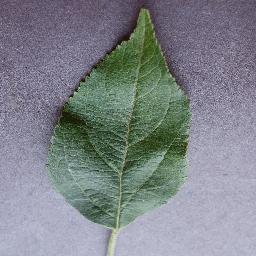

In [ ]:
x=image.img_to_array(img)

In [ ]:
x

In [ ]:
x=np.expand_dims(x,axis=0)

In [ ]:
x

In [ ]:
y=np.argmax(model.predict(x),axis=1)

In [ ]:
x_train.class_indices

In [ ]:
index=['Apple___Black_rot','Apple___healthy','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Peach___Bacterial_spot','Peach___healthy']

In [ ]:
index[y[0]]

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
y=np.argmax(model.predict(x),axis=1)
index=['Apple___Black_rot','Apple___healthy','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Peach___Bacterial_spot','Peach___healthy']
index[y[0]]

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from flask import Flask,render_template,request

In [ ]:
app=Flask(__name__)

model=load_model("fruit.h5")

@app.route('/')
def index():
    return render_template("index.html")

@app.route('/predict',methods=['GET','POST'])
def upload():
    if request.method=='POST':
        f=request.files['image']
        basepath=os.path.dirname('__file__')
        filepath=os.path.join(basepath,'uploads',f.filename)
        f.save(filepath)
        img=image.load_img(filepath,target_size=(128,128))
        x=image.img_to_array(img)
        x=np.expand_dims(x,axis=0)
        pred=np.argmax(model.predict(x),axis=1)
        index=['Apple___Black_rot','Apple___healthy','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Peach___Bacterial_spot','Peach___healthy']
        text="The Classified Fruit disease is : " +str(index[pred[0]])
    return text
if __name__=='__main__':
    app.run(debug=False)